In [1]:
from google.colab import drive
import jax.numpy as jnp
from jax.nn import swish, hard_swish, relu
from jax import grad, jit, vmap, value_and_grad, jacfwd
from jax.experimental import optimizers
from jax import random
from math import pi
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import sys
import time
from tqdm.notebook import tqdm
import plotly.graph_objects as go
from scipy import interpolate
from mpl_toolkits import mplot3d

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
def subsample_vector(inp, scale):
  ssv = np.zeros((int(len(inp)/scale), ))
  for i in range(0, len(inp), scale):
    b = int(i/scale)
    ssv[b] = inp[i]
  return ssv

#def subsample_matrix(inp, scale):
#  ssm = np.zeros([int(len(inp[:,0,0])/scale), int(len(inp[0,:,0])/scale), int(len(inp[0,0,:])/scale)])
#  for i in range(0, len(inp[:,0,0]) , scale ):
#    for j in range(0, len(inp[0,:,0]) , scale ):
#      for k in range(0, len(inp[0,0,:]) , scale ):
#        a = int(i/scale)
#        b = int(j/scale)
#        c = int(k/scale)
#        ssm[a,b,c] = inp[i,j,k]
#  return ssm

def subsample_matrix(inp, scale):
  ssm = np.zeros([int(len(inp[:,0,0])/scale), int(len(inp[0,:,0])/scale), int(len(inp[0,0,:])/scale)])
  for i in range(0, len(inp[:,0,0]) , scale ):
    for j in range(0, len(inp[0,:,0]) , scale ):
      for k in range(0, len(inp[0,0,:]) , scale ):
        ssm[int(i/scale), int(j/scale), int(k/scale)] = inp[i, j, k]
  return ssm

In [3]:
def random_layer_params(m, n, key):
  w_key, b_key = random.split(key)
  scale = jnp.sqrt(2.0/m) # HE Initialisation
  #scale = jnp.sqrt(6.0/m)
  return scale * random.normal(w_key, (n, m), jnp.float64), scale * random.normal(b_key, (n,), jnp.float64) #use for swish
  #return random.uniform(w_key, (n, m), jnp.float32, -scale, scale), random.uniform(b_key, (n,), jnp.float32, -scale, scale) #use for sin

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

In [4]:
#NN 
def fx(params, x, y, z):
  # per-example predictions
  activations = jnp.hstack([x, y, z])
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b
    activations = swish(outputs) #better than sin or tanh
    #activations = 0.5*jnp.sin(outputs)
  
  final_w, final_b = params[-1]
  func =  jnp.dot(final_w, activations) + final_b
  funcc = func[0]
  return funcc.reshape()

def fy(params, x, y, z):
  # per-example predictions
  activations = jnp.hstack([x, y, z])
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b
    activations = swish(outputs) #better than sin or tanh
    #activations = 0.5*jnp.sin(outputs)
  
  final_w, final_b = params[-1]
  func =  jnp.dot(final_w, activations) + final_b
  funcc = func[1]
  return funcc.reshape()

def fz(params, x, y, z):
  # per-example predictions
  activations = jnp.hstack([x, y, z])
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b
    activations = swish(outputs) #better than sin or tanh
    #activations = 0.5*jnp.sin(outputs)
  
  final_w, final_b = params[-1]
  func =  jnp.dot(final_w, activations) + final_b 
  funcc = func[2]
  return funcc.reshape()

def fzfy(params, x, y, z):
  return grad(fz, 2)(params, x, y, z) - grad(fy, 3)(params, x, y, z)
  
def fxfz(params, x, y, z):
  return grad(fx, 3)(params, x, y, z) - grad(fz, 1)(params, x, y, z)
  
def fyfx(params, x, y, z):
  return grad(fy, 1)(params, x, y, z) - grad(fx, 2)(params, x, y, z)
  

In [5]:
#def residue_f_con(params, x, y, z): 
 # return jnp.square(grad(fx, 1)(params, x, y, z) + grad(fy, 2)(params, x, y, z) + grad(fz, 3)(params, x, y, z)) + jnp.square(grad(grad(fzfy, 1), 1)(params, x, y, z) + grad(grad(fxfz, 2), 2)(params, x, y, z) + grad(grad(fyfx, 3), 3)(params, x, y, z)) 

#def residue_f_con_cont(params, x, y, z): 
 # return jnp.square(grad(fx, 1)(params, x, y, z) + grad(fy, 2)(params, x, y, z) + grad(fz, 3)(params, x, y, z))   

#def residue_f_con_mom(params, x, y, z): 
 # return jnp.square(grad(grad(fzfy, 1), 1)(params, x, y, z) + grad(grad(fxfz, 2), 2)(params, x, y, z) + grad(grad(fyfx, 3), 3)(params, x, y, z)) 

In [6]:
#def residue_f_con_cont(params, x, y, z): 
 # return jnp.square(grad(fx, 1)(params, x, y, z) + grad(fy, 2)(params, x, y, z) + grad(fz, 3)(params, x, y, z))   

#def residue_f_con_mom(params, x, y, z): 
 # return jnp.square(grad(grad(fzfy, 1), 1)(params, x, y, z) + grad(grad(fzfy, 2), 2)(params, x, y, z) + grad(grad(fzfy, 3), 3)(params, x, y, z)) +  jnp.square(grad(grad(fxfz, 1), 1)(params, x, y, z) + grad(grad(fxfz, 2), 2)(params, x, y, z) + grad(grad(fxfz, 3), 3)(params, x, y, z)) + jnp.square(grad(grad(fyfx, 1), 1)(params, x, y, z) + grad(grad(fyfx, 2), 2)(params, x, y, z) + grad(grad(fyfx, 3), 3)(params, x, y, z))

#def residue_f_con(params, x, y, z):
 # return  jnp.square(grad(fx, 1)(params, x, y, z) + grad(fy, 2)(params, x, y, z) + grad(fz, 3)(params, x, y, z)) + jnp.square(grad(grad(fzfy, 1), 1)(params, x, y, z) + grad(grad(fzfy, 2), 2)(params, x, y, z) + grad(grad(fzfy, 3), 3)(params, x, y, z)) +  jnp.square(grad(grad(fxfz, 1), 1)(params, x, y, z) + grad(grad(fxfz, 2), 2)(params, x, y, z) + grad(grad(fxfz, 3), 3)(params, x, y, z)) + jnp.square(grad(grad(fyfx, 1), 1)(params, x, y, z) + grad(grad(fyfx, 2), 2)(params, x, y, z) + grad(grad(fyfx, 3), 3)(params, x, y, z))
  #return residue_f_con_cont(params, x, y, z) + residue_f_con_mom(params, x, y, z)

In [7]:
def residue_f_con_cont(params, x, y, z): 
  a = jnp.square(grad(fx, 1)(params, x, y, z) + grad(fy, 2)(params, x, y, z) + grad(fz, 3)(params, x, y, z))
  return a   

def residue_f_con_mom(params, x, y, z):
  u_x = fx(params, x, y, z)
  u_y = fy(params, x, y, z)
  u_z = fz(params, x, y, z)

  om_x = fzfy(params, x, y, z)
  om_y = fxfz(params, x, y, z)
  om_z = fyfx(params, x, y, z)

  a = jnp.square(0.001*(grad(grad(fzfy, 1), 1)(params, x, y, z) + grad(grad(fzfy, 2), 2)(params, x, y, z) + grad(grad(fzfy, 3), 3)(params, x, y, z)) + (om_x*grad(fx, 1)(params, x, y, z) + om_y*grad(fx, 2)(params, x, y, z) + om_z*grad(fx, 3)(params, x, y, z)) - (u_x*grad(fzfy, 1)(params, x, y, z) + u_y*grad(fzfy, 2)(params, x, y, z) + u_z*grad(fzfy, 3)(params, x, y, z)))
  b = jnp.square(0.001*(grad(grad(fxfz, 1), 1)(params, x, y, z) + grad(grad(fxfz, 2), 2)(params, x, y, z) + grad(grad(fxfz, 3), 3)(params, x, y, z)) + (om_x*grad(fy, 1)(params, x, y, z) + om_y*grad(fy, 2)(params, x, y, z) + om_z*grad(fy, 3)(params, x, y, z)) - (u_x*grad(fxfz, 1)(params, x, y, z) + u_y*grad(fxfz, 2)(params, x, y, z) + u_z*grad(fxfz, 3)(params, x, y, z)))
  c = jnp.square(0.001*(grad(grad(fyfx, 1), 1)(params, x, y, z) + grad(grad(fyfx, 2), 2)(params, x, y, z) + grad(grad(fyfx, 3), 3)(params, x, y, z)) + (om_x*grad(fz, 1)(params, x, y, z) + om_y*grad(fz, 2)(params, x, y, z) + om_z*grad(fz, 3)(params, x, y, z)) - (u_x*grad(fyfx, 1)(params, x, y, z) + u_y*grad(fyfx, 2)(params, x, y, z) + u_z*grad(fyfx, 3)(params, x, y, z)))
  return a + b + c

def residue_f_con(params, x, y, z):
  u_x = fx(params, x, y, z)
  u_y = fy(params, x, y, z)
  u_z = fz(params, x, y, z)

  om_x = fzfy(params, x, y, z)
  om_y = fxfz(params, x, y, z)
  om_z = fyfx(params, x, y, z)

  a = jnp.square(grad(fx, 1)(params, x, y, z) + grad(fy, 2)(params, x, y, z) + grad(fz, 3)(params, x, y, z))
  b = jnp.square(0.001*(grad(grad(fzfy, 1), 1)(params, x, y, z) + grad(grad(fzfy, 2), 2)(params, x, y, z) + grad(grad(fzfy, 3), 3)(params, x, y, z)) + (om_x*grad(fx, 1)(params, x, y, z) + om_y*grad(fx, 2)(params, x, y, z) + om_z*grad(fx, 3)(params, x, y, z)) - (u_x*grad(fzfy, 1)(params, x, y, z) + u_y*grad(fzfy, 2)(params, x, y, z) + u_z*grad(fzfy, 3)(params, x, y, z)))
  c = jnp.square(0.001*(grad(grad(fxfz, 1), 1)(params, x, y, z) + grad(grad(fxfz, 2), 2)(params, x, y, z) + grad(grad(fxfz, 3), 3)(params, x, y, z)) + (om_x*grad(fy, 1)(params, x, y, z) + om_y*grad(fy, 2)(params, x, y, z) + om_z*grad(fy, 3)(params, x, y, z)) - (u_x*grad(fxfz, 1)(params, x, y, z) + u_y*grad(fxfz, 2)(params, x, y, z) + u_z*grad(fxfz, 3)(params, x, y, z)))
  d = jnp.square(0.001*(grad(grad(fyfx, 1), 1)(params, x, y, z) + grad(grad(fyfx, 2), 2)(params, x, y, z) + grad(grad(fyfx, 3), 3)(params, x, y, z)) + (om_x*grad(fz, 1)(params, x, y, z) + om_y*grad(fz, 2)(params, x, y, z) + om_z*grad(fz, 3)(params, x, y, z)) - (u_x*grad(fyfx, 1)(params, x, y, z) + u_y*grad(fyfx, 2)(params, x, y, z) + u_z*grad(fyfx, 3)(params, x, y, z)))
  return a + b + c + d

In [8]:
batched_fx = vmap(fx, in_axes=(None, 0, 0, 0))
batched_fy = vmap(fy, in_axes=(None, 0, 0, 0))
batched_fz = vmap(fz, in_axes=(None, 0, 0, 0))
batched_fzfy = vmap(fzfy, in_axes=(None, 0, 0, 0))
batched_fxfz = vmap(fxfz, in_axes=(None, 0, 0, 0))
batched_fyfx = vmap(fyfx, in_axes=(None, 0, 0, 0))
batched_residue_f_con = vmap(residue_f_con, in_axes=(None, 0, 0, 0))
batched_residue_f_con_cont = vmap(residue_f_con_cont, in_axes=(None, 0, 0, 0))
batched_residue_f_con_mom = vmap(residue_f_con_mom, in_axes=(None, 0, 0, 0))

In [9]:
def nn_data_loss_noicbc(params, x_d, y_d, z_d, x_dat, y_dat, z_dat, v_dat, res_wt, reg_wt):  ##what are x_d and y_d, res_wt and reg_wt

  #reg_loss = 0.0
  #for w, b in params:
  #  reg_loss = reg_loss  + jnp.linalg.norm(w)
  #  reg_loss = reg_loss + jnp.linalg.norm(b)
 
  residue = batched_residue_f_con(params, x_d, y_d, z_d)
  vel_zero = jnp.square(batched_fx(params, x_d, y_d, z_d)) + jnp.square(batched_fy(params, x_d, y_d, z_d)) + jnp.square(batched_fz(params, x_d, y_d, z_d))
  residue_loss = jnp.mean(jnp.minimum(residue, vel_zero))
  data_loss = jnp.mean(jnp.square(batched_fx(params, x_dat, y_dat, z_dat) - v_dat[:,0]) + 15157*jnp.square(batched_fy(params, x_dat, y_dat, z_dat) - v_dat[:,1]) + 15157*jnp.square(batched_fz(params, x_dat, y_dat, z_dat) - v_dat[:,2])) 
  loss = res_wt*(residue_loss) +(1.0 - res_wt)*(data_loss) #+ reg_wt*reg_loss
  return loss

In [10]:
@jit
def update_data_noicbc(params, x_d, y_d, z_d, x_dat, y_dat, z_dat, v_dat, res_wt, reg_wt, opt_state): ##what is opt_state?
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(nn_data_loss_noicbc)(params, x_d, y_d, z_d, x_dat, y_dat, z_dat, v_dat, res_wt, reg_wt)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value  ##what does this function do and where does opt_update come from

In [11]:
@jit
def nn_boundary_loss(params, x_d, y_d, z_d, x_b, y_b, z_b, x_dat, y_dat, z_dat, v_dat, b_margin): ##what are x_b, b_margin?
  # per-example predictions
  bc_loss = jnp.mean(jnp.square(batched_fx(params, x_b, y_b, z_b) - b_margin) + jnp.square(batched_fy(params, x_b, y_b, z_b) - b_margin) + jnp.square(batched_fz(params, x_b, y_b, z_b) - b_margin))
  return bc_loss

In [12]:
@jit
def update_boundary(params, x_d, y_d, z_d, x_b, y_b, z_b, x_dat, y_dat, z_dat, v_dat, b_margin, step_size):
  grad_x = grad(nn_boundary_loss, 4)(params, x_d, y_d, z_d, x_b, y_b, z_b, x_dat, y_dat, z_dat, v_dat, b_margin)
  grad_y = grad(nn_boundary_loss, 5)(params, x_d, y_d, z_d, x_b, y_b, z_b, x_dat, y_dat, z_dat, v_dat, b_margin)
  grad_z = grad(nn_boundary_loss, 6)(params, x_d, y_d, z_d, x_b, y_b, z_b, x_dat, y_dat, z_dat, v_dat, b_margin)
  return (x_b - step_size_b * grad_x), (y_b - step_size_b * grad_y), (z_b - step_size_b*grad_z)

In [13]:
def accuracy(ux, uy, uz, ux_r, uy_r, uz_r):
  ex = np.linalg.norm(ux - ux_r)/np.linalg.norm(ux_r)
  ey = np.linalg.norm(uy - uy_r)/np.linalg.norm(uy_r)
  ez = np.linalg.norm(uz - uz_r)/np.linalg.norm(uz_r)
  e_av = (ex + ey + ez)/3
  print('Accuracy_x =', np.round(100 - ex*100, 2),'%,', 'Accuracy_y =' ,np.round(100 - ey*100, 2), '%,', 'Accuracy_z =', np.round(100 - ez*100, 2), '%,', 'Accuracy_average =', np.round(100 - e_av*100, 2), '%')
  return 

In [14]:
x_dat, y_dat, z_dat = np.meshgrid(np.linspace(-1, 1, 800), np.linspace(-0.74843554, 0.74843554, 200), np.linspace(-0.74843554, 0.748435,200))
print(np.shape(x_dat))

(200, 800, 200)


In [15]:
x_dat_ss_2 = subsample_matrix(x_dat, 2)
y_dat_ss_2 = subsample_matrix(y_dat, 2)
z_dat_ss_2 = subsample_matrix(z_dat, 2)

x_dat_ss_4 = subsample_matrix(x_dat, 4)
y_dat_ss_4 = subsample_matrix(y_dat, 4)
z_dat_ss_4 = subsample_matrix(z_dat, 4)

x_dat_ss_5 = subsample_matrix(x_dat, 5)
y_dat_ss_5 = subsample_matrix(y_dat, 5)
z_dat_ss_5 = subsample_matrix(z_dat, 5)

x_dat_ss = subsample_matrix(x_dat, 10)
y_dat_ss = subsample_matrix(y_dat, 10)
z_dat_ss = subsample_matrix(z_dat, 10)

x_dat_ss_20 = subsample_matrix(x_dat, 20)
y_dat_ss_20 = subsample_matrix(y_dat, 20)
z_dat_ss_20 = subsample_matrix(z_dat, 20)

In [16]:
x_datt = x_dat
y_datt = y_dat
z_datt = z_dat

x_dat = x_dat.flatten()
y_dat = y_dat.flatten()
z_dat = z_dat.flatten()

In [17]:
ux = np.load('/content/gdrive/My Drive/3D_STEADY_NSTOKES/KV_0P001/ux.npy', allow_pickle=True)
uy = np.load('/content/gdrive/My Drive/3D_STEADY_NSTOKES/KV_0P001/uy.npy', allow_pickle=True)
uz = np.load('/content/gdrive/My Drive/3D_STEADY_NSTOKES/KV_0P001/uz.npy', allow_pickle=True)

uxr = ux
uyr = uy
uzr = uz

ux_ss_4 = subsample_matrix(ux, 4)
uy_ss_4 = subsample_matrix(uy, 4)
uz_ss_4 = subsample_matrix(uz, 4)

spacing_x = 0.0025
spacing_y = 0.00748436
spacing_z = 0.00748436
dxdydz = spacing_x * spacing_y * spacing_z
volume = 4.4812461
SNR = 0.3

variance_x = np.square((np.sum(np.abs(ux)) * dxdydz * (1/volume)))/SNR
variance_y = np.square((np.sum(np.abs(uy)) * dxdydz * (1/volume)))/SNR
variance_z = np.square((np.sum(np.abs(uz)) * dxdydz * (1/volume)))/SNR

print(1/variance_x)
print(1/variance_y)
print(1/variance_z)

31.096645045260573
471326.2364131848
471326.23641318694


Text(0.5, 0.98, 'Ground Truth Velocity Field (Not seen by PINN)')

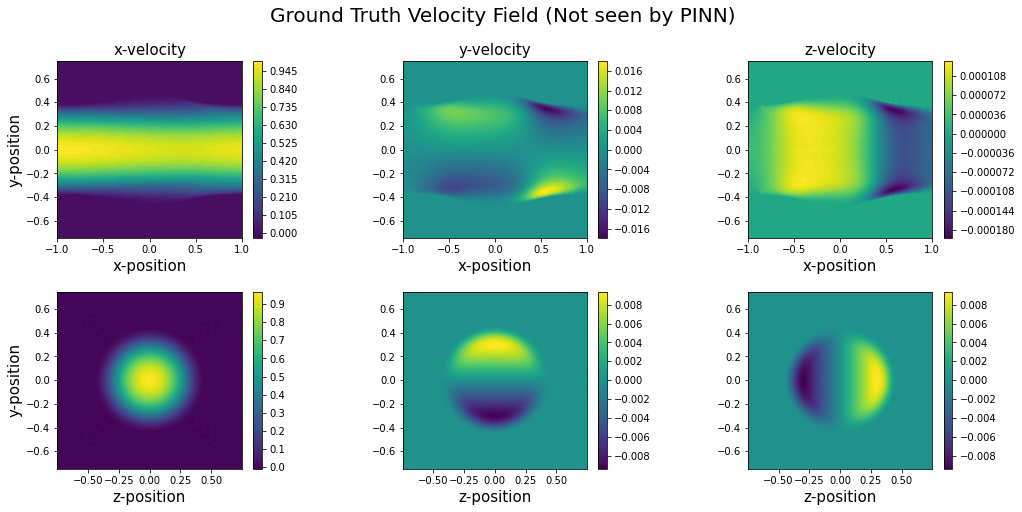

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(16.5, 7.5))

axs_0_0 = axs[0, 0].tricontourf(x_datt[:, :, 100].flatten(), y_datt[:, :, 100].flatten() , ux[:, :, 100].flatten(), 100)
fig.colorbar(axs_0_0, ax=axs[0, 0])

axs_0_1 = axs[0, 1].tricontourf(x_datt[:, :, 100].flatten(), y_datt[:, :, 100].flatten() , uy[:, :, 100].flatten(), 100)
fig.colorbar(axs_0_1, ax=axs[0, 1])

axs_0_2 = axs[0, 2].tricontourf(x_datt[:, :, 100].flatten(), y_datt[:, :, 100].flatten() , uz[:, :, 100].flatten(), 100)
fig.colorbar(axs_0_2, ax=axs[0, 2])

axs_1_0 = axs[1, 0].tricontourf(z_datt[:, 300, :].flatten(), y_datt[:, 300, :].flatten() , ux[:, 300, :].flatten(), 100)
fig.colorbar(axs_1_0, ax=axs[1, 0])

axs_1_1 = axs[1, 1].tricontourf(z_datt[:, 300, :].flatten(), y_datt[:, 300, :].flatten() , uy[:, 300, :].flatten(), 100)
fig.colorbar(axs_1_1, ax=axs[1, 1])

axs_1_2 = axs[1, 2].tricontourf(z_datt[:, 300, :].flatten(), y_datt[:, 300, :].flatten() , uz[:, 300, :].flatten(), 100)
fig.colorbar(axs_1_2, ax=axs[1, 2])

fig.subplots_adjust(wspace = 0.5, hspace = 0.3)

axs[0, 0].set_title('x-velocity', size =15)
axs[0, 1].set_title('y-velocity', size =15)
axs[0, 2].set_title('z-velocity', size =15)

axs[0, 0].set_xlabel('x-position', size =15)
axs[0, 1].set_xlabel('x-position', size =15)
axs[0, 2].set_xlabel('x-position', size =15)

axs[1, 0].set_xlabel('z-position', size =15)
axs[1, 1].set_xlabel('z-position', size =15)
axs[1, 2].set_xlabel('z-position', size =15)

axs[0, 0].set_ylabel('y-position', size =15)
axs[1, 0].set_ylabel('y-position', size =15)

fig.suptitle('Ground Truth Velocity Field (Not seen by PINN)', size = 20)

Text(0.5, 0.98, 'Ground Truth Velocity Field (Not seen by PINN)')

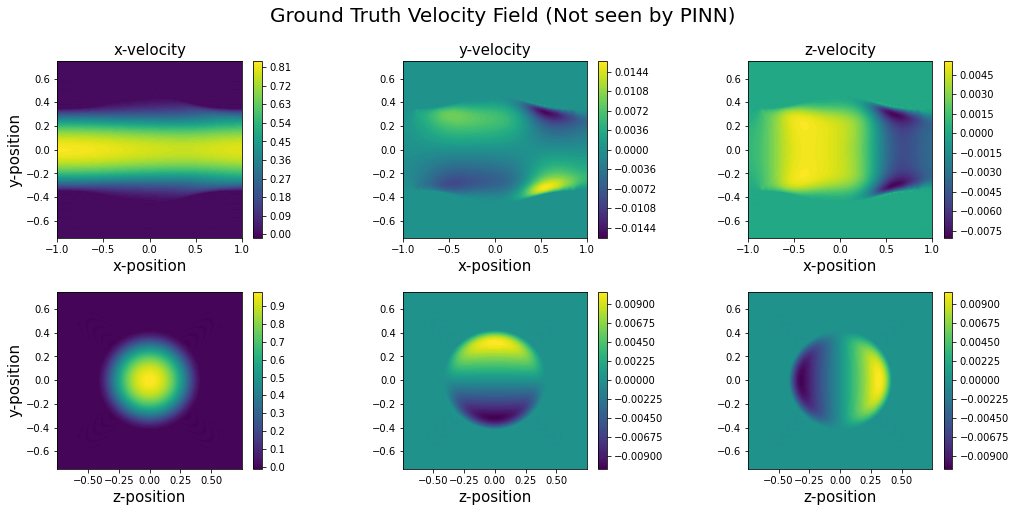

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(16.5, 7.5))

axs_0_0 = axs[0, 0].tricontourf(x_datt[:, :, 120].flatten(), y_datt[:, :, 120].flatten() , ux[:, :, 120].flatten(), 100)
fig.colorbar(axs_0_0, ax=axs[0, 0])

axs_0_1 = axs[0, 1].tricontourf(x_datt[:, :, 120].flatten(), y_datt[:, :, 120].flatten() , uy[:, :, 120].flatten(), 100)
fig.colorbar(axs_0_1, ax=axs[0, 1])

axs_0_2 = axs[0, 2].tricontourf(x_datt[:, :, 120].flatten(), y_datt[:, :, 120].flatten() , uz[:, :, 120].flatten(), 100)
fig.colorbar(axs_0_2, ax=axs[0, 2])

axs_1_0 = axs[1, 0].tricontourf(z_datt[:, 225, :].flatten(), y_datt[:, 225, :].flatten() , ux[:, 225, :].flatten(), 100)
fig.colorbar(axs_1_0, ax=axs[1, 0])

axs_1_1 = axs[1, 1].tricontourf(z_datt[:, 225, :].flatten(), y_datt[:, 225, :].flatten() , uy[:, 225, :].flatten(), 100)
fig.colorbar(axs_1_1, ax=axs[1, 1])

axs_1_2 = axs[1, 2].tricontourf(z_datt[:, 225, :].flatten(), y_datt[:, 225, :].flatten() , uz[:, 225, :].flatten(), 100)
fig.colorbar(axs_1_2, ax=axs[1, 2])

fig.subplots_adjust(wspace = 0.5, hspace = 0.3)

axs[0, 0].set_title('x-velocity', size =15)
axs[0, 1].set_title('y-velocity', size =15)
axs[0, 2].set_title('z-velocity', size =15)

axs[0, 0].set_xlabel('x-position', size =15)
axs[0, 1].set_xlabel('x-position', size =15)
axs[0, 2].set_xlabel('x-position', size =15)

axs[1, 0].set_xlabel('z-position', size =15)
axs[1, 1].set_xlabel('z-position', size =15)
axs[1, 2].set_xlabel('z-position', size =15)

axs[0, 0].set_ylabel('y-position', size =15)
axs[1, 0].set_ylabel('y-position', size =15)

fig.suptitle('Ground Truth Velocity Field (Not seen by PINN)', size = 20)

In [18]:
k1 = random.PRNGKey(0)
k2 = random.PRNGKey(10)
k3 = random.PRNGKey(20)

ux = np.add(ux, random.normal(k1, ux.shape, jnp.float64) * np.sqrt(variance_x))
uy = np.add(uy, random.normal(k2, uy.shape, jnp.float64) * np.sqrt(variance_y))
uz = np.add(uz, random.normal(k3, uz.shape, jnp.float64) * np.sqrt(variance_z))

In [19]:
v_dat = jnp.column_stack([ux.flatten(), uy.flatten(), uz.flatten()])

Text(0.5, 0.98, 'Noisy Velocity Field (Reference used by PINN)')

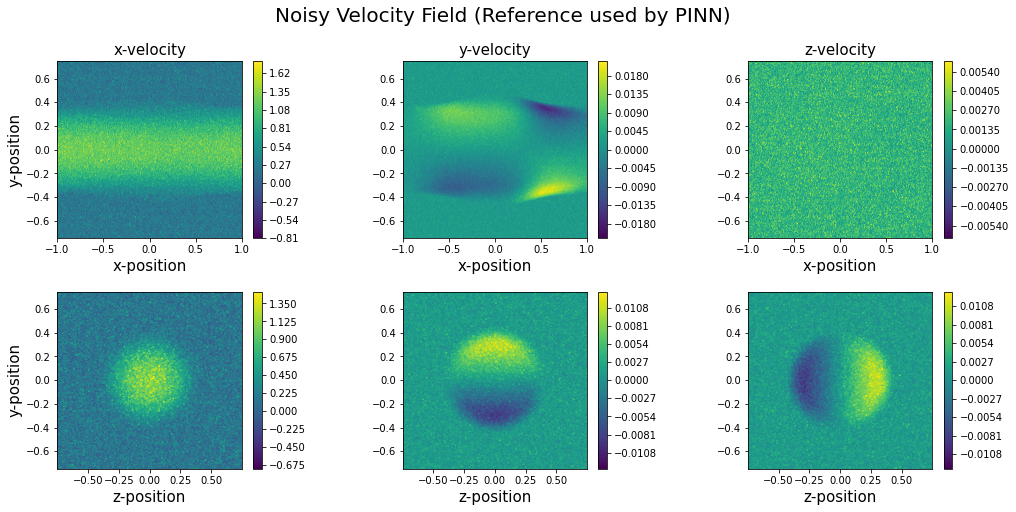

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(16.5, 7.5))

axs_0_0 = axs[0, 0].tricontourf(x_datt[:, :, 100].flatten(), y_datt[:, :, 100].flatten() , ux[:, :, 100].flatten(), 100)
fig.colorbar(axs_0_0, ax=axs[0, 0])

axs_0_1 = axs[0, 1].tricontourf(x_datt[:, :, 100].flatten(), y_datt[:, :, 100].flatten() , uy[:, :, 100].flatten(), 100)
fig.colorbar(axs_0_1, ax=axs[0, 1])

axs_0_2 = axs[0, 2].tricontourf(x_datt[:, :, 100].flatten(), y_datt[:, :, 100].flatten() , uz[:, :, 100].flatten(), 100)
fig.colorbar(axs_0_2, ax=axs[0, 2])

axs_1_0 = axs[1, 0].tricontourf(z_datt[:, 300, :].flatten(), y_datt[:, 300, :].flatten() , ux[:, 300, :].flatten(), 100)
fig.colorbar(axs_1_0, ax=axs[1, 0])

axs_1_1 = axs[1, 1].tricontourf(z_datt[:, 300, :].flatten(), y_datt[:, 300, :].flatten() , uy[:, 300, :].flatten(), 100)
fig.colorbar(axs_1_1, ax=axs[1, 1])

axs_1_2 = axs[1, 2].tricontourf(z_datt[:, 300, :].flatten(), y_datt[:, 300, :].flatten() , uz[:, 300, :].flatten(), 100)
fig.colorbar(axs_1_2, ax=axs[1, 2])

fig.subplots_adjust(wspace = 0.5, hspace = 0.3)

axs[0, 0].set_title('x-velocity', size =15)
axs[0, 1].set_title('y-velocity', size =15)
axs[0, 2].set_title('z-velocity', size =15)

axs[0, 0].set_xlabel('x-position', size =15)
axs[0, 1].set_xlabel('x-position', size =15)
axs[0, 2].set_xlabel('x-position', size =15)

axs[1, 0].set_xlabel('z-position', size =15)
axs[1, 1].set_xlabel('z-position', size =15)
axs[1, 2].set_xlabel('z-position', size =15)

axs[0, 0].set_ylabel('y-position', size =15)
axs[1, 0].set_ylabel('y-position', size =15)

fig.suptitle('Noisy Velocity Field (Reference used by PINN)', size = 20)

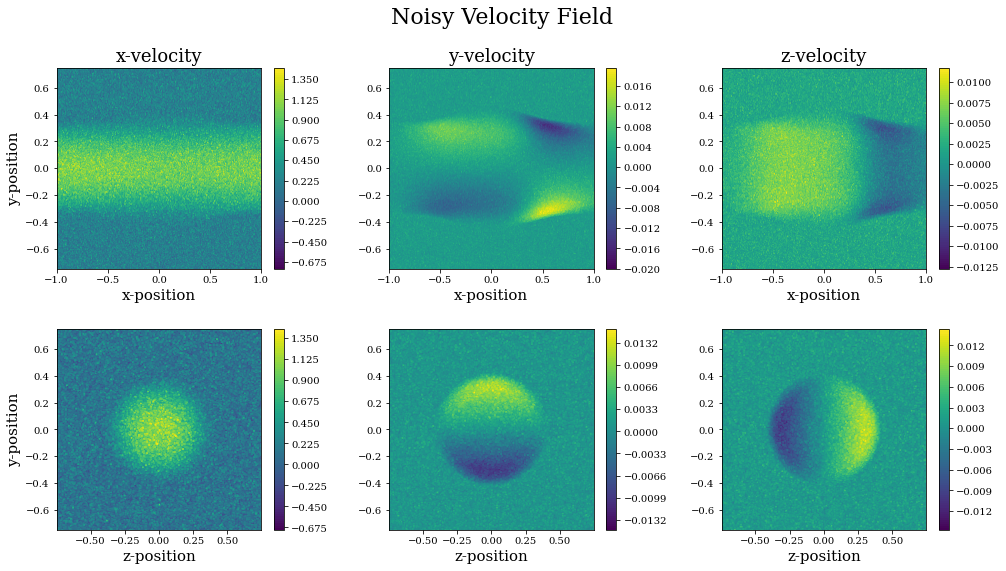

In [20]:
fig, axs = plt.subplots(2, 3, figsize=(16.5, 8.5))

axs_0_0 = axs[0, 0].tricontourf(x_datt[:, :, 120].flatten(), y_datt[:, :, 120].flatten() , ux[:, :, 120].flatten(), 100)
fig.colorbar(axs_0_0, ax=axs[0, 0])

axs_0_1 = axs[0, 1].tricontourf(x_datt[:, :, 120].flatten(), y_datt[:, :, 120].flatten() , uy[:, :, 120].flatten(), 100)
fig.colorbar(axs_0_1, ax=axs[0, 1])

axs_0_2 = axs[0, 2].tricontourf(x_datt[:, :, 120].flatten(), y_datt[:, :, 120].flatten() , uz[:, :, 120].flatten(), 100)
fig.colorbar(axs_0_2, ax=axs[0, 2])

axs_1_0 = axs[1, 0].tricontourf(z_datt[:, 225, :].flatten(), y_datt[:, 225, :].flatten() , ux[:, 225, :].flatten(), 100)
fig.colorbar(axs_1_0, ax=axs[1, 0])

axs_1_1 = axs[1, 1].tricontourf(z_datt[:, 225, :].flatten(), y_datt[:, 225, :].flatten() , uy[:, 225, :].flatten(), 100)
fig.colorbar(axs_1_1, ax=axs[1, 1])

axs_1_2 = axs[1, 2].tricontourf(z_datt[:, 225, :].flatten(), y_datt[:, 225, :].flatten() , uz[:, 225, :].flatten(), 100)
fig.colorbar(axs_1_2, ax=axs[1, 2])

fig.subplots_adjust(wspace = 0.3, hspace = 0.3)

axs[0, 0].set_title('x-velocity', size =18)
axs[0, 1].set_title('y-velocity', size =18)
axs[0, 2].set_title('z-velocity', size =18)

axs[0, 0].set_xlabel('x-position', size =15)
axs[0, 1].set_xlabel('x-position', size =15)
axs[0, 2].set_xlabel('x-position', size =15)

axs[1, 0].set_xlabel('z-position', size =15)
axs[1, 1].set_xlabel('z-position', size =15)
axs[1, 2].set_xlabel('z-position', size =15)

axs[0, 0].set_ylabel('y-position', size =15)
axs[1, 0].set_ylabel('y-position', size =15)

fig.suptitle('Noisy Velocity Field', size = 22)

plt.savefig('/content/gdrive/My Drive/3D_STEADY_NSTOKES/KV_0P001/KV0P001_noisy')

In [ ]:
#initial guess fit data

for n in [0.01, 0.03, 0.05, 2.718]:

  num_epochs = 10001
  layer_sizes = [3, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 3] 
  #layer_sizes = [3, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 3] 
  #layer_sizes = [3, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 3] 
  #layer_sizes = [3, 500, 500, 500, 500, 500, 500, 500, 500, 3]
  params = init_network_params(layer_sizes, random.PRNGKey(78))

  step_size = 1e-3
  opt_init, opt_update, get_params = optimizers.sm3(step_size)
  opt_state = opt_init(params)
  num_b = 128
  reg_wt = 0
  res_wt = 0

  loss = 0
  loss_history = []

  for i in tqdm(range(num_epochs)):
  
    if ((i% 100 == 0)):

      print()

      if ((i%1000 == 0)):
        !nvidia-smi

      if n == 2.718:
        res_wt = 1 - jnp.exp(-i/200000.0)
      else:
        if i >= 5000:
          res_wt = n

      plt.plot(loss_history[100:], 'k' )
      plt.show()
    
      ux_f = batched_fx(params, x_dat_ss.flatten(), y_dat_ss.flatten(), z_dat_ss.flatten())
      ux_f = ux_f.reshape(20, 80, 20)

      uy_f = batched_fy(params, x_dat_ss.flatten(), y_dat_ss.flatten(), z_dat_ss.flatten())
      uy_f = uy_f.reshape(20, 80, 20)

      uz_f = batched_fz(params, x_dat_ss.flatten(), y_dat_ss.flatten(), z_dat_ss.flatten())
      uz_f = uz_f.reshape(20, 80, 20)

      fig, axs = plt.subplots(2, 3, figsize=(16.5, 7.5))

      axs_0_0 = axs[0, 0].tricontourf(x_dat_ss[:, :, 12].flatten(), y_dat_ss[:, :, 12].flatten() , ux_f[:, :, 12].flatten(), 100)
      fig.colorbar(axs_0_0, ax=axs[0, 0])

      axs_0_1 = axs[0, 1].tricontourf(x_dat_ss[:, :, 12].flatten(), y_dat_ss[:, :, 12].flatten() , uy_f[:, :, 12].flatten(), 100)
      fig.colorbar(axs_0_1, ax=axs[0, 1])

      axs_0_2 = axs[0, 2].tricontourf(x_dat_ss[:, :, 12].flatten(), y_dat_ss[:, :, 12].flatten() , uz_f[:, :, 12].flatten(), 100)
      fig.colorbar(axs_0_2, ax=axs[0, 2])

      axs_1_0 = axs[1, 0].tricontourf(z_dat_ss[:, 22, :].flatten(), y_dat_ss[:, 22, :].flatten() , ux_f[:, 22, :].flatten(), 100)
      fig.colorbar(axs_1_0, ax=axs[1, 0])

      axs_1_1 = axs[1, 1].tricontourf(z_dat_ss[:, 22, :].flatten(), y_dat_ss[:, 22, :].flatten() , uy_f[:, 22, :].flatten(), 100)
      fig.colorbar(axs_1_1, ax=axs[1, 1])

      axs_1_2 = axs[1, 2].tricontourf(z_dat_ss[:, 22, :].flatten(), y_dat_ss[:, 22, :].flatten() , uz_f[:, 22, :].flatten(), 100)
      fig.colorbar(axs_1_2, ax=axs[1, 2])

      fig.subplots_adjust(wspace = 0.5, hspace = 0.3)

      axs[0, 0].set_title('x-velocity', size =15)
      axs[0, 1].set_title('y-velocity', size =15)
      axs[0, 2].set_title('z-velocity', size =15)

      axs[0, 0].set_xlabel('x-position', size =15)
      axs[0, 1].set_xlabel('x-position', size =15)
      axs[0, 2].set_xlabel('x-position', size =15)

      axs[1, 0].set_xlabel('z-position', size =15)
      axs[1, 1].set_xlabel('z-position', size =15)
      axs[1, 2].set_xlabel('z-position', size =15)

      axs[0, 0].set_ylabel('y-position', size =15)
      axs[1, 0].set_ylabel('y-position', size =15)

      fig.suptitle('Reconstructed Velocity Field (Output of PINN), Residual Weight ' + str(n) + ', Epoch ' + str(i),  size = 20)

      plt.show()

      #res_wt = 1 - jnp.exp(-i/200000.0)

      print('i:', i)
      print('loss:', loss)
      print('res_wt:', res_wt)
    
      np.save('/content/gdrive/My Drive/3D_STEADY_NSTOKES/KV_0P001/params_0.3_30_225_' + str(n) + '.npy', params, allow_pickle=True)
      np.save('/content/gdrive/My Drive/3D_STEADY_NSTOKES/KV_0P001/loss_history_0.3_30_225_' + str(n) + '.npy', loss_history, allow_pickle=True)

    key = random.PRNGKey(i)
    key2 = random.PRNGKey(i+3)
    key3 = random.PRNGKey(i+6)
    x_d = random.uniform(key, (512,), jnp.float64, -1, 1)
    y_d = random.uniform(key2, (512,), jnp.float64, -0.74843554, 0.74843554)
    z_d = random.uniform(key3, (512,), jnp.float64, -0.74843554, 0.74843554)

    indices = random.choice(key, jnp.arange(x_dat.shape[0]), shape=(2048,), replace=False, p=None)
    x_dat_sample = x_dat[indices]
    y_dat_sample = y_dat[indices]
    z_dat_sample = z_dat[indices]
    v_dat_sample = v_dat[indices, :]

    params, opt_state, loss = update_data_noicbc(params, x_d, y_d, z_d, x_dat_sample, y_dat_sample, z_dat_sample, v_dat_sample, res_wt, reg_wt, opt_state)
    loss_history.append(loss)

    pass

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
params = np.load('/content/gdrive/My Drive/3D_STEADY_NSTOKES/KV_0P001/params_0.3_30_225_2.718.npy', allow_pickle=True)

ux_f = batched_fx(params, x_dat_ss_4.flatten(), y_dat_ss_4.flatten(), z_dat_ss_4.flatten())
ux_f = ux_f.reshape(50, 200, 50)

uy_f = batched_fy(params, x_dat_ss_4.flatten(), y_dat_ss_4.flatten(), z_dat_ss_4.flatten())
uy_f = uy_f.reshape(50, 200, 50)

uz_f = batched_fz(params, x_dat_ss_4.flatten(), y_dat_ss_4.flatten(), z_dat_ss_4.flatten())
uz_f = uz_f.reshape(50, 200, 50)

u_mag = jnp.sqrt(jnp.square(ux_f) + jnp.square(uy_f) + jnp.square(uz_f))

accuracy(ux_f, uy_f, uz_f, ux_ss_4, uy_ss_4, uz_ss_4)

Accuracy_x = 90.89 %, Accuracy_y = 85.21 %, Accuracy_z = 84.56 %, Accuracy_average = 86.89 %


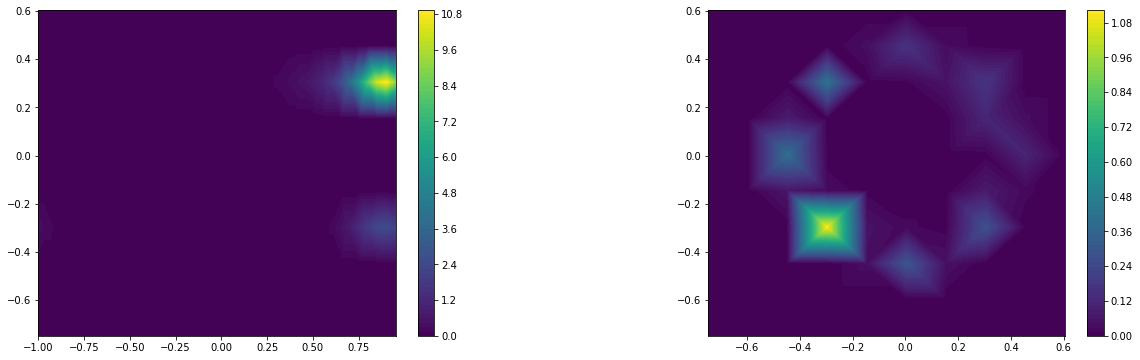

In [ ]:
residuals = batched_residue_f_con(params, x_dat_ss_20.flatten(), y_dat_ss_20.flatten(), z_dat_ss_20.flatten())
residuals = residuals.reshape(10, 40, 10)

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

axs_0_0 = axs[0].tricontourf(x_dat_ss_20[:, :, 6].flatten(), y_dat_ss_20[:, :, 6].flatten() , residuals[:, :, 6].flatten(), levels = 100)
fig.colorbar(axs_0_0, ax=axs[0])

axs_0_1 = axs[1].tricontourf(z_dat_ss_20[:, 11, :].flatten(), y_dat_ss_20[:, 11, :].flatten() , residuals[:, 11, :].flatten(), levels = 100)
fig.colorbar(axs_0_1, ax=axs[1])


fig.subplots_adjust(wspace = 0.5)

plt.show()

fig = go.Figure(data=go.Volume(
    x=x_dat_ss_20.flatten(),
    y=y_dat_ss_20.flatten(),
    z=z_dat_ss_20.flatten(),
    value=residuals.flatten(),
    isomin=0,
    isomax=float(jnp.amax(residuals)),
    opacity=0.2, # needs to be small to see through all surfaces
    surface_count=100, # needs to be a large number for good volume rendering
    ))
fig.show()

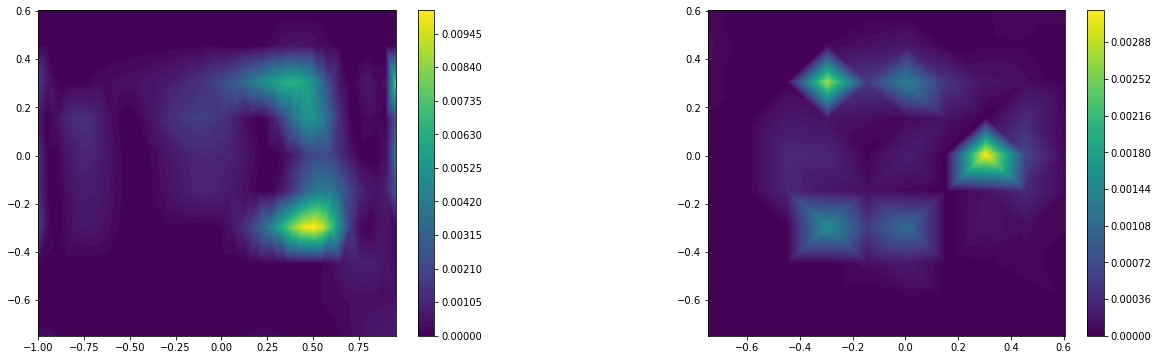

In [ ]:
residuals_cont = batched_residue_f_con_cont(params, x_dat_ss_20.flatten(), y_dat_ss_20.flatten(), z_dat_ss_20.flatten())
residuals_cont = residuals_cont.reshape(10, 40, 10)

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

axs_0_0 = axs[0].tricontourf(x_dat_ss_20[:, :, 6].flatten(), y_dat_ss_20[:, :, 6].flatten() , residuals_cont[:, :, 6].flatten(), levels = 100)
fig.colorbar(axs_0_0, ax=axs[0])

axs_0_1 = axs[1].tricontourf(z_dat_ss_20[:, 11, :].flatten(), y_dat_ss_20[:, 11, :].flatten() , residuals_cont[:, 11, :].flatten(), levels = 100)
fig.colorbar(axs_0_1, ax=axs[1])


fig.subplots_adjust(wspace = 0.5)

plt.show()

fig = go.Figure(data=go.Volume(
    x=x_dat_ss_20.flatten(),
    y=y_dat_ss_20.flatten(),
    z=z_dat_ss_20.flatten(),
    value=residuals_cont.flatten(),
    isomin=0,
    isomax=float(jnp.amax(residuals_cont)),
    opacity=0.2, # needs to be small to see through all surfaces
    surface_count=100, # needs to be a large number for good volume rendering
    ))
fig.show()

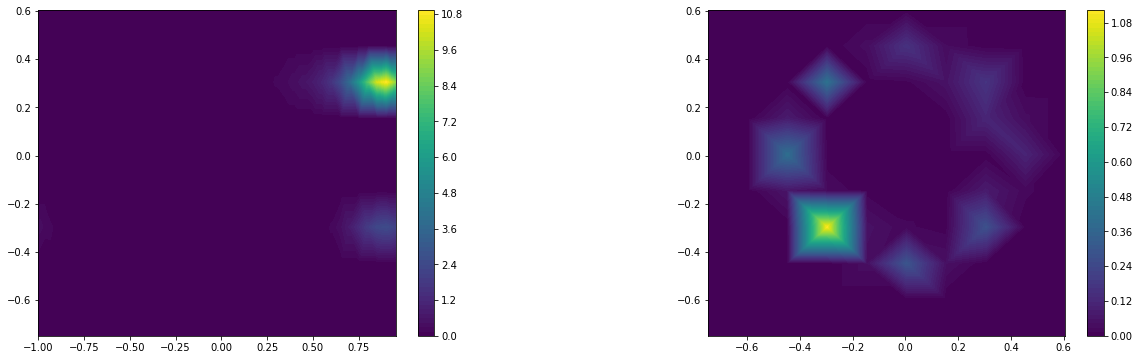

In [ ]:
residuals_mom = batched_residue_f_con_mom(params, x_dat_ss_20.flatten(), y_dat_ss_20.flatten(), z_dat_ss_20.flatten())
residuals_mom = residuals_mom.reshape(10, 40, 10)

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

axs_0_0 = axs[0].tricontourf(x_dat_ss_20[:, :, 6].flatten(), y_dat_ss_20[:, :, 6].flatten() , residuals_mom[:, :, 6].flatten(), levels = 100)
fig.colorbar(axs_0_0, ax=axs[0])

axs_0_1 = axs[1].tricontourf(z_dat_ss_20[:, 11, :].flatten(), y_dat_ss_20[:, 11, :].flatten() , residuals_mom[:, 11, :].flatten(), levels = 100)
fig.colorbar(axs_0_1, ax=axs[1])


fig.subplots_adjust(wspace = 0.5)

plt.show()

fig = go.Figure(data=go.Volume(
    x=x_dat_ss_20.flatten(),
    y=y_dat_ss_20.flatten(),
    z=z_dat_ss_20.flatten(),
    value=residuals_mom.flatten(),
    isomin=0,
    isomax=float(jnp.amax(residuals_mom)),
    opacity=0.2, # needs to be small to see through all surfaces
    surface_count=100, # needs to be a large number for good volume rendering
    ))
fig.show()

In [ ]:
ux_f = batched_fx(params, x_dat_ss_4.flatten(), y_dat_ss_4.flatten(), z_dat_ss_4.flatten())
ux_f = ux_f.reshape(50, 200, 50)

uy_f = batched_fy(params, x_dat_ss_4.flatten(), y_dat_ss_4.flatten(), z_dat_ss_4.flatten())
uy_f = uy_f.reshape(50, 200, 50)

uz_f = batched_fz(params, x_dat_ss_4.flatten(), y_dat_ss_4.flatten(), z_dat_ss_4.flatten())
uz_f = uz_f.reshape(50, 200, 50)

u_mag = jnp.sqrt(jnp.square(ux_f) + jnp.square(uy_f) + jnp.square(uz_f))

accuracy(ux_f, uy_f, uz_f, ux_ss_4, uy_ss_4, uz_ss_4)

Accuracy_x = 96.0 %, Accuracy_y = 68.45 %, Accuracy_z = 70.66 %, Accuracy_average = 78.37 %


In [ ]:
ux_f_nrl = batched_fx(params_nrl, x_dat_ss_4.flatten(), y_dat_ss_4.flatten(), z_dat_ss_4.flatten())
ux_f_nrl = ux_f_nrl.reshape(50, 200, 50)

uy_f_nrl = batched_fy(params_nrl, x_dat_ss_4.flatten(), y_dat_ss_4.flatten(), z_dat_ss_4.flatten())
uy_f_nrl = uy_f_nrl.reshape(50, 200, 50)

uz_f_nrl = batched_fz(params_nrl, x_dat_ss_4.flatten(), y_dat_ss_4.flatten(), z_dat_ss_4.flatten())
uz_f_nrl = uz_f_nrl.reshape(50, 200, 50)

u_mag_nrl = jnp.sqrt(jnp.square(ux_f_nrl) + jnp.square(uy_f_nrl) + jnp.square(uz_f_nrl))

accuracy(ux_f_nrl, uy_f_nrl, uz_f_nrl, ux_ss_4, uy_ss_4, uz_ss_4)

Accuracy_x = 95.12 %, Accuracy_y = 70.97 %, Accuracy_z = 62.78 %, Accuracy_average = 76.29 %


In [ ]:
key = random.PRNGKey(1)
key2 = random.PRNGKey(2)
key3 = random.PRNGKey(3)
x_d = random.uniform(key, (4000,), jnp.float64, -0.9, 0.9)
y_d = random.uniform(key2, (4000,), jnp.float64, -0.35, 0.35)
z_d = random.uniform(key3, (4000,), jnp.float64, -0.35, 0.35)

residualss = batched_residue_f_con(params, x_d, y_d, z_d)
#residuals_4 = residuals_4.reshape(10, 40, 10)
print(np.sum(np.abs(residualss))/4000)

residuals_nrl = batched_residue_f_con(params_nrl, x_d, y_d, z_d)
#residuals_5 = residuals_5.reshape(10, 40, 10)
print(np.sum(np.abs(residuals_nrl))/4000)

0.35716107177734374
0.4688458251953125


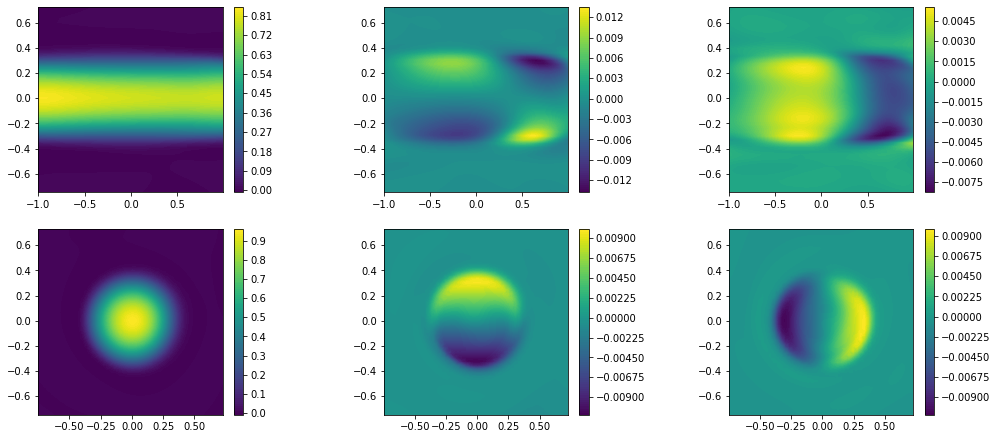

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(16.5, 7.5))

axs_0_0 = axs[0, 0].tricontourf(x_dat_ss_4[:, :, 30].flatten(), y_dat_ss_4[:, :, 30].flatten() , ux_f[:, :, 30].flatten(), 100)
fig.colorbar(axs_0_0, ax=axs[0, 0])

axs_0_1 = axs[0, 1].tricontourf(x_dat_ss_4[:, :, 30].flatten(), y_dat_ss_4[:, :, 30].flatten() , uy_f[:, :, 30].flatten(), 100)
fig.colorbar(axs_0_1, ax=axs[0, 1])

axs_0_2 = axs[0, 2].tricontourf(x_dat_ss_4[:, :, 30].flatten(), y_dat_ss_4[:, :, 30].flatten() , uz_f[:, :, 30].flatten(), 100)
fig.colorbar(axs_0_2, ax=axs[0, 2])

axs_1_0 = axs[1, 0].tricontourf(z_dat_ss_4[:, 75, :].flatten(), y_dat_ss_4[:, 75, :].flatten() , ux_f[:, 75, :].flatten(), 100)
fig.colorbar(axs_1_0, ax=axs[1, 0])

axs_1_1 = axs[1, 1].tricontourf(z_dat_ss_4[:, 75, :].flatten(), y_dat_ss_4[:, 75, :].flatten() , uy_f[:, 75, :].flatten(), 100)
fig.colorbar(axs_1_1, ax=axs[1, 1])

axs_1_2 = axs[1, 2].tricontourf(z_dat_ss_4[:, 75, :].flatten(), y_dat_ss_4[:, 75, :].flatten() , uz_f[:, 75, :].flatten(), 100)
fig.colorbar(axs_1_2, ax=axs[1, 2])

fig.subplots_adjust(wspace = 0.5, hspace=0.3)

axs[0, 0].set_title('x-velocity', size =24)
axs[0, 1].set_title('y-velocity', size =24)
axs[0, 2].set_title('z-velocity', size =24)

axs[0, 0].set_xlabel('x-position', size =15)
axs[0, 1].set_xlabel('x-position', size =15)
axs[0, 2].set_xlabel('x-position', size =15)

axs[1, 0].set_xlabel('z-position', size =15)
axs[1, 1].set_xlabel('z-position', size =15)
axs[1, 2].set_xlabel('z-position', size =15)

axs[0, 0].set_ylabel('y-position', size =15)
axs[1, 0].set_ylabel('y-position', size =15)

fig.suptitle('Reconstructed Velocity Field (Output of PINN)', size = 20)

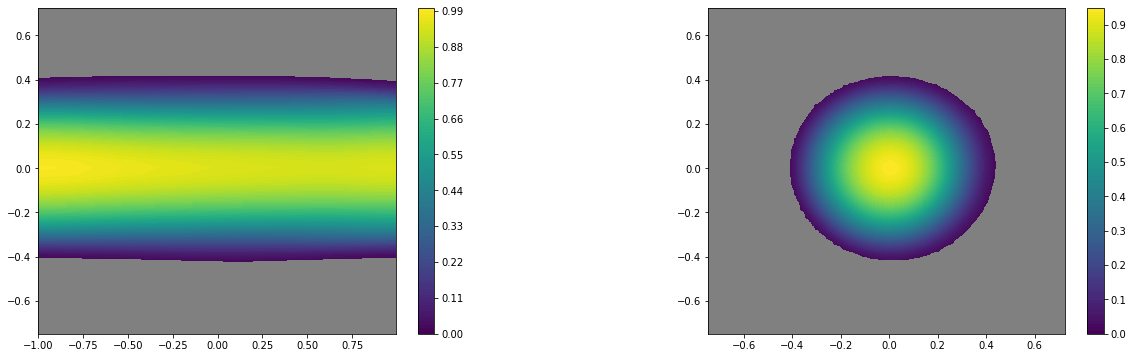

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

axs_0_0 = axs[0].tricontourf(x_dat_ss_4[:, :, 25].flatten(), y_dat_ss_4[:, :, 25].flatten() , u_mag[:, :, 25].flatten(), levels = 100)
fig.colorbar(axs_0_0, ax=axs[0])
axs_0_0 = axs[0].tricontourf(x_dat_ss_4[:, :, 25].flatten(), y_dat_ss_4[:, :, 25].flatten() , u_mag[:, :, 25].flatten(), levels = [0, 0.017], colors = 'grey')

axs_0_1 = axs[1].tricontourf(z_dat_ss_4[:, 100, :].flatten(), y_dat_ss_4[:, 100, :].flatten() , u_mag[:, 100, :].flatten(), levels = 100)
fig.colorbar(axs_0_1, ax=axs[1])
axs_0_1 = axs[1].tricontourf(z_dat_ss_4[:, 100, :].flatten(), y_dat_ss_4[:, 100, :].flatten() , u_mag[:, 100, :].flatten(), levels = [0, 0.02], colors = 'grey')

fig.subplots_adjust(wspace = 0.5)

plt.show()

In [ ]:
ux_interp = interpolate.RegularGridInterpolator((np.linspace(-0.74843554, 0.74843554, 50), np.linspace(-1, 1, 200)), ux_f[:, :, 25])
uy_interp = interpolate.RegularGridInterpolator((np.linspace(-0.74843554, 0.74843554, 50), np.linspace(-1, 1, 200)), uy_f[:, :, 25])

uxr_interp = interpolate.RegularGridInterpolator((np.linspace(-0.74843554, 0.74843554, 200), np.linspace(-1, 1, 800)), uxr[:, :, 100])
uyr_interp = interpolate.RegularGridInterpolator((np.linspace(-0.74843554, 0.74843554, 200), np.linspace(-1, 1, 800)), uyr[:, :, 100])

In [ ]:
time_step=0.01
velocity = np.array([ux_interp((0.35, -1)), uy_interp((0.35, -1))])
velocity = velocity.reshape(1,2)

position_t = np.array([-1, 0.35])
position_t = position_t.reshape(1,2)

new_position = np.array([1, 1])
new_position = new_position.reshape(1,2)

for i in range(3000):

  position_update = velocity*time_step
  new_position = position_t[-1,:] + position_update
 
  if np.absolute(new_position[0, 0] <= 0.99) and np.absolute(new_position[0, 1] <= 0.74):
     position_t = np.vstack((position_t, new_position))
     velocity = np.array([ux_interp((new_position[0, 1], new_position[0, 0])), uy_interp((new_position[0, 1], new_position[0, 0]))])
     velocity = velocity.reshape(1, 2)
  elif np.absolute(new_position[0, 0] > 1) or np.absolute(new_position[0, 1] > 0.74):
     break

In [ ]:
time_step=0.01
velocity = np.array([ux_interp((-0.35, -1)), uy_interp((-0.35, -1))])
velocity = velocity.reshape(1,2)

position_b = np.array([-1, -0.35])
position_b = position_b.reshape(1,2)

new_position = np.array([1, 1])
new_position = new_position.reshape(1,2)

for i in range(3000):

  position_update = velocity*time_step
  new_position = position_b[-1,:] + position_update
 
  if np.absolute(new_position[0, 0] <= 0.99) and np.absolute(new_position[0, 1] <= 0.74):
     position_b = np.vstack((position_b, new_position))
     velocity = np.array([ux_interp((new_position[0, 1], new_position[0, 0])), uy_interp((new_position[0, 1], new_position[0, 0]))])
     velocity = velocity.reshape(1, 2)
  elif np.absolute(new_position[0, 0] > 1) or np.absolute(new_position[0, 1] > 0.74):
     break

In [ ]:
time_step=0.01
velocity = np.array([uxr_interp((0.35, -1)), uyr_interp((0.35, -1))])
velocity = velocity.reshape(1,2)

position_t_r = np.array([-1, 0.35])
position_t_r = position_t_r.reshape(1,2)

new_position = np.array([1, 1])
new_position = new_position.reshape(1,2)

for i in range(3000):

  position_update = velocity*time_step
  new_position = position_t_r[-1,:] + position_update
 
  if np.absolute(new_position[0, 0] <= 0.99) and np.absolute(new_position[0, 1] <= 0.74):
     position_t_r = np.vstack((position_t_r, new_position))
     velocity = np.array([uxr_interp((new_position[0, 1], new_position[0, 0])), uyr_interp((new_position[0, 1], new_position[0, 0]))])
     velocity = velocity.reshape(1, 2)
  elif np.absolute(new_position[0, 0] > 1) or np.absolute(new_position[0, 1] > 0.74):
     break

In [ ]:
time_step=0.01
velocity = np.array([uxr_interp((-0.35, -1)), uyr_interp((-0.35, -1))])
velocity = velocity.reshape(1,2)

position_b_r = np.array([-1, -0.35])
position_b_r = position_b_r.reshape(1,2)

new_position = np.array([1, 1])
new_position = new_position.reshape(1,2)

for i in range(3000):

  position_update = velocity*time_step
  new_position = position_b_r[-1,:] + position_update
 
  if np.absolute(new_position[0, 0] <= 0.99) and np.absolute(new_position[0, 1] <= 0.74):
     position_b_r = np.vstack((position_b_r, new_position))
     velocity = np.array([uxr_interp((new_position[0, 1], new_position[0, 0])), uyr_interp((new_position[0, 1], new_position[0, 0]))])
     velocity = velocity.reshape(1, 2)
  elif np.absolute(new_position[0, 0] > 1) or np.absolute(new_position[0, 1] > 0.74):
     break

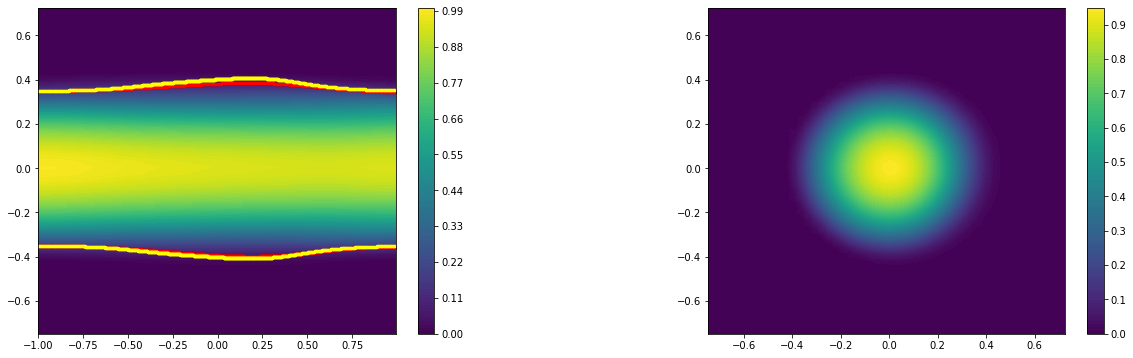

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

axs_0_0 = axs[0].tricontourf(x_dat_ss_4[:, :, 25].flatten(), y_dat_ss_4[:, :, 25].flatten() , u_mag[:, :, 25].flatten(), levels = 100)
#plt.scatter(position[:,0], position[:,1])
fig.colorbar(axs_0_0, ax=axs[0])
axs[0].scatter(position_t[:,0], position_t[:,1], c = 'red', s=5)
axs[0].scatter(position_b[:,0], position_b[:,1], c = 'red', s=5)
axs[0].scatter(position_t_r[:,0], position_t_r[:,1], c = 'yellow', s=5)
axs[0].scatter(position_b_r[:,0], position_b_r[:,1], c = 'yellow', s=5)

axs_0_1 = axs[1].tricontourf(z_dat_ss_4[:, 100, :].flatten(), y_dat_ss_4[:, 100, :].flatten() , u_mag[:, 100, :].flatten(), levels = 100)
fig.colorbar(axs_0_1, ax=axs[1])

fig.subplots_adjust(wspace = 0.5)

axs[0].set_title('Velocity Magnitude and Flow Shape', size =15)
axs[0].set_xlabel('x-position', size =15)
axs[0].set_ylabel('y-position', size =15)
axs[0].legend(loc='lower right', framealpha = 0.4)

plt.show() 

In [ ]:
ux_interp_3D = interpolate.RegularGridInterpolator((np.linspace(-0.74843554, 0.74843554, 50), np.linspace(-1, 1, 200), np.linspace(-0.74843554, 0.74843554, 50)), ux_f)
uy_interp_3D = interpolate.RegularGridInterpolator((np.linspace(-0.74843554, 0.74843554, 50), np.linspace(-1, 1, 200), np.linspace(-0.74843554, 0.74843554, 50)), uy_f)
uz_interp_3D = interpolate.RegularGridInterpolator((np.linspace(-0.74843554, 0.74843554, 50), np.linspace(-1, 1, 200), np.linspace(-0.74843554, 0.74843554, 50)), uz_f)

In [ ]:
y_center = 0
z_center = 0
radius = 0.35
yI = np.array([0.35])
zI = np.array([0])
angle = 0*pi/180;

while angle < 360*pi/180:
  angle = angle + (5*pi/180)
  yI = np.vstack((yI, y_center + radius * np.cos(angle)))
  zI = np.vstack((zI, z_center + radius * np.sin(angle)))

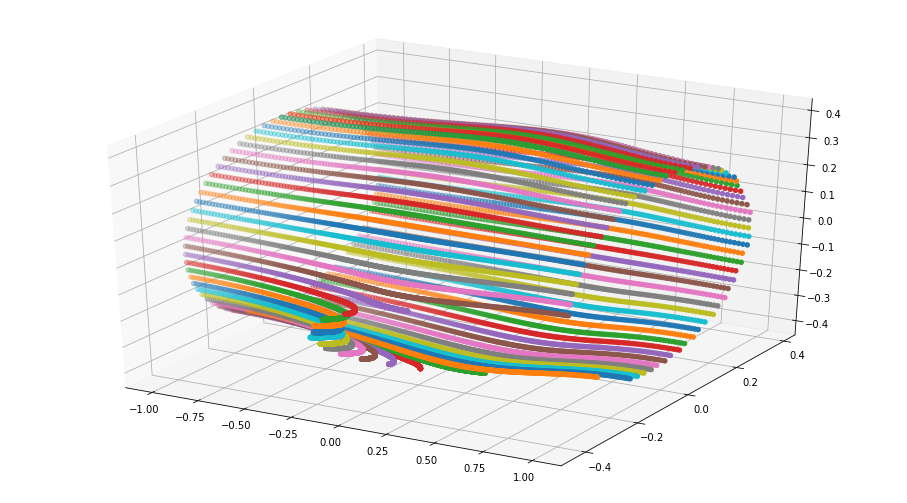

In [ ]:
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
ax.grid(b = True, color ='grey',
       linestyle ='-', linewidth = 0.3,
       alpha = 0.2)

time_step=0.1

for i, j in zip(yI, zI):
  velocity = np.array([ux_interp_3D((float(i), -1, float(j))), uy_interp_3D((float(i), -1, float(j))), uz_interp_3D((float(i), -1, float(j)))])
  velocity = velocity.reshape(1,3)

  position = np.array([-1, float(i), float(j)])
  position = position.reshape(1,3)

  new_position = np.array([1, 1, 1])
  new_position = new_position.reshape(1,3)

  for i in range(500):

    position_update = velocity*time_step
    new_position = position[-1,:] + position_update
 
    if np.absolute(new_position[0, 0] <= 1) and np.absolute(new_position[0, 1] <= 0.74) and np.absolute(new_position[0, 2] <= 0.74) and i < 499:
       position = np.vstack((position, new_position))
       velocity = np.array([ux_interp_3D((new_position[0, 1], new_position[0, 0], new_position[0,2])), uy_interp_3D((new_position[0, 1], new_position[0, 0], new_position[0,2])), uz_interp_3D((new_position[0, 1], new_position[0, 0], new_position[0,2]))])
       velocity = velocity.reshape(1, 3)
    elif np.absolute(new_position[0, 0] > 1) or np.absolute(new_position[0, 1] > 0.74) or np.absolute(new_position[0, 2] > 0.74) or i == 499:
       ax.scatter3D(position[:,0], position[:,2], position[:,1])
       break
plt.show()

In [ ]:
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
ax.grid(b = True, color ='grey',
       linestyle ='-.', linewidth = 0.3,
       alpha = 0.2)
my_cmap = plt.get_cmap('hsv')

time_step=0.1

for i, j in zip(yI, zI):
  velocity = np.array([ux_interp_3D((float(i), -1, float(j))), uy_interp_3D((float(i), -1, float(j))), 0])
  velocity = velocity.reshape(1,3)

  position = np.array([-1, float(i), float(j)])
  position = position.reshape(1,3)

  new_position = np.array([1, 1, 1])
  new_position = new_position.reshape(1,3)

  for i in range(500):

    position_update = velocity*time_step
    new_position = position[-1,:] + position_update
 
    if np.absolute(new_position[0, 0] <= 1) and np.absolute(new_position[0, 1] <= 0.74) and np.absolute(new_position[0, 2] <= 0.74) and i < 499:
       position = np.vstack((position, new_position))
       velocity = np.array([ux_interp_3D((new_position[0, 1], new_position[0, 0], new_position[0,2])), uy_interp_3D((new_position[0, 1], new_position[0, 0], new_position[0,2])), uz_interp_3D((new_position[0, 1], new_position[0, 0], new_position[0,2]))])
       velocity = velocity.reshape(1, 3)
    elif np.absolute(new_position[0, 0] > 1) or np.absolute(new_position[0, 1] > 0.74) or np.absolute(new_position[0, 2] > 0.74) or i == 499:
       ax.scatter3D(position[:,0], position[:,2], position[:,1])
       ax.scatter3D(position[:,0], position[:,2], -1*position[:,1])
       break
plt.show()

In [ ]:
u_mag_ref = jnp.sqrt(jnp.square(ux) + jnp.square(uy) + jnp.square(uz))
u_mag_ref_ss = subsample_matrix(u_mag_ref, 10)

In [ ]:
ux_f_ss_10 = batched_fx(params, x_dat_ss.flatten(), y_dat_ss.flatten(), z_dat_ss.flatten())
ux_f_ss_10 = ux_f_ss_10.reshape(20, 80, 20)

uy_f_ss_10 = batched_fy(params, x_dat_ss.flatten(), y_dat_ss.flatten(), z_dat_ss.flatten())
uy_f_ss_10 = uy_f_ss_10.reshape(20, 80, 20)

uz_f_ss_10 = batched_fz(params, x_dat_ss.flatten(), y_dat_ss.flatten(), z_dat_ss.flatten())
uz_f_ss_10 = uz_f_ss_10.reshape(20, 80, 20)

u_mag_ss_10 = jnp.sqrt(jnp.square(ux_f_ss_10) + jnp.square(uy_f_ss_10) + jnp.square(uz_f_ss_10))

In [ ]:
fig = go.Figure(data=go.Volume(
    x=x_dat_ss.flatten(),
    y=y_dat_ss.flatten(),
    z=z_dat_ss.flatten(),
    value=u_mag_ref_ss.flatten(),
    isomin=0.1,
    isomax=float(jnp.amax(u_mag_ref_ss)),
    opacity=0.2, # needs to be small to see through all surfaces
    surface_count=100, # needs to be a large number for good volume rendering
    ))
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
fig = go.Figure(data=go.Volume(
    x=x_dat_ss.flatten(),
    y=y_dat_ss.flatten(),
    z=z_dat_ss.flatten(),
    value=u_mag_ss_10.flatten(),
    isomin=0.1,
    isomax=float(jnp.amax(u_mag_ss_10)),
    opacity=0.2, # needs to be small to see through all surfaces
    surface_count=100, # needs to be a large number for good volume rendering
    ))
fig.show()

Output hidden; open in https://colab.research.google.com to view.